# Case 8

## Business Problem

We are working at logistics at an important supermarket in the country. So, your task is to deliver necessary amount of goods to each customer (satisfy customer demand and factories production capacity) at minimal total transportation cost.

## Packages Import

In [ ]:
import numpy as np
import random as rd
import time
import matplotlib.pyplot as pl
from IPython import display

## Data Definition

Let’s consider simplified transportation type problem. We have set of customers I = [1,2,3,4,5] and set of factories J = [1,2,3]. Each customer has some fixed product demand d_i and each factory has fixed production capacity M_j. There are also fixed transportation costs to deliver one unit of good from factory j to customer i.

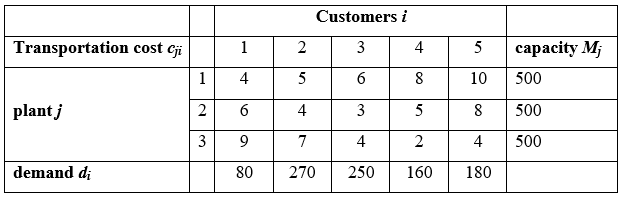

In [ ]:
display.Image("./Images/Data_definition.png")

In [ ]:
d = {1:80, 2:270, 3:250, 4:160, 5:180}  # customer demand
M = {1:500, 2:500, 3:500}               # factory capacity
I = [1,2,3,4,5]                         # Customers
J = [1,2,3]                             # Factories
cost = {(1,1):4,    (1,2):6,    (1,3):9,
     (2,1):5,    (2,2):4,    (2,3):7,
     (3,1):6,    (3,2):3,    (3,3):3,
     (4,1):8,    (4,2):5,    (4,3):3,
     (5,1):10,   (5,2):8,    (5,3):4
   }                                    # transportation costs

# Transform cost dictionary into 2D array
cost2d = np.empty([len(I), len(J)])
for i in range(len(I)):
    for j in range(len(J)):
        cost2d[i,j] = cost[i+1,j+1]


# Variables bounds
n_vars = cost2d.size    # number of variables
bounds =3* [(80), (270), (250), (160), (180)]

In [ ]:
print(cost2d)
print(n_vars)

[[ 4.  6.  9.]
 [ 5.  4.  7.]
 [ 6.  3.  3.]
 [ 8.  5.  3.]
 [10.  8.  4.]]
15


## Problem Definition

To formulate this situation as optimization problem we must separate it into 3 main components:

- **decision variables** — quantities of goods to be sent from factory j to customer i (positive real numbers)
- **constraints** — total amount of goods must satisfy both customer demand and factory production capacity (equalities/inequalities that have linear expression on the left-hand side)
- **objective function** — find such values of decision variables that total transportation cost is the lowest (linear expression in this case)

Problem has I binding constraints: sum of goods must be equal to customer demand. And J non-binding constraints: sum of goods sent must be no greater than factory production capacity.

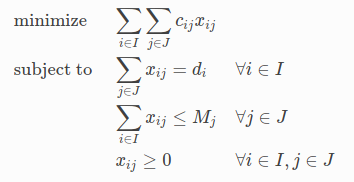

In [ ]:
display.Image("./Images/Problem_definition.png")

## Exact Solution

The exact solution of objective function is 3350 and nonzero variable values are as follows.

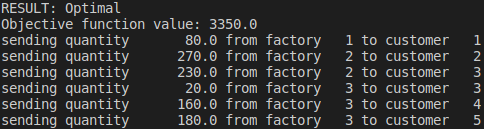

In [ ]:
display.Image("./Images/Exact_solution.png")

## Meta-heuristic Solution

In Meta-heuristics, constraints cannot exist sepparate from the objective function so, for this case, we are going tconvert constraints into penalties and include them into objective function.

Penalty in this case would be a unit of violation of constraint. For customer demand constraint, corresponding penalty could be written as max(0, abs(sum_j(goods_ij) - demand_i)**2. 

Because this constraint is binding, violation can be positive or negative, hence abs() in penalty. Raising penalty to power 2 is just to make it more severe. For factory capacity constraint, corresponding penalty could be written as max(0, (sum_i(goods_ij) - capacity_j)**3. No abs() needed as constraint violation can be only positive in this case. Choice of power to raise penalty to is arbitrary. Power of 3 seemed to yield more consistently lower objective function values for this particular problem.

Basically, we are converting initial hard constraints into soft constraints, allowing for some of them being violated. Hence, sub-optimal solutions as a result.

In [ ]:
class problem:
    def __init__ (self,Maximize = False):
        self.Maximize = Maximize
        self.funtion_value = 0

    def define_if_maximization_problem(self, Bool):
        self.esMax = Bool
    
    def  problem_function(x):
        obj_func = 0
        sum_index = 0
        for client in range(len(I)):
            for factory in range(len(J)):
            
                obj_func += x[sum_index] * cost[client+1,factory+1]
                
                sum_index += 1

        # Penalty: sum of all factories outputs == customer_i demand
        pen_cust_demand = 0
        for idx in range(0, cost2d.size, len(J)):
            pen_cust_demand += (max(0, abs(sum(x[idx: idx + len(J)]) - d[idx//len(J) + 1])))**2
            
        obj_func += 2*pen_cust_demand
        
        # Penalty: sum of all customers demands <= factory_j capacity
        pen_fact_capacity = 0
        for idx in range(0, cost2d.size, len(I)):
            pen_fact_capacity += (max(0, (sum(x[idx: idx + len(I)]) - M[idx//len(I) + 1])))**3
        
        obj_func += 2*pen_fact_capacity
        
        return obj_func

In [ ]:
class stop_criteria:
    def __init__ (self,max_iterations, max_tolerance):
        self.max_iterations = max_iterations
        self.max_tolerance = max_tolerance
        self.tolerance_criteria = False
        self.max_iter_criteria = False

    def define_tolerance_criteria(self,result1,result2):
        difference = abs(abs(result1)-abs(result2))
        if difference < self.max_tolerance:
            self.tolerance_criteria = True
    
    def define_max_iter_criteria(self,iteration_number):
        if iteration_number >= self.max_iterations:
            self.max_iter_criteria = True

    def reset_tolerance_criteria(self):
        self.tolerance_criteria = False

    def reset_max_iter_criteria(self):
        self.max_iter_criteria = False

In [ ]:
class metaheuristics:
    def __init__ (self):
        self.current_iteration = 0
        self.stop_criteria
        self.problem
        self.current_solution # x1
        self.next_solution # x2
        self.current_result = 0 # F(x1)
        self.next_result = 0 # F(x2)

    def define_stop_criteria(self, new_criteria):
        self.stop_criteria = new_criteria

    def initialize_solution(self,initial_value):
        self.current_solution = initial_value

    def define_problem(self, new_problem):
        self.problem = new_problem

    def reset_iteration(self):
        self.current_iteration = 0

    def run_search(self):

        self.reset_iteration(self)
        
        self.run_method(self)

    def increase_iteration(self):
        self.current_iteration += 1

In [ ]:
class hill_climbing(metaheuristics):
    def __init__(self):
        super().__init__(self)

    def keep_or_discard(self):
        if self.next_result < self.current_result:
            self.current_solution = self.next_solution

    def run_method(self):
        metaheuristics.reset_iteration(self)
        metaheuristics.increase_iteration(self)
        stop_criteria.reset_tolerance_criteria(self)
        stop_criteria.reset_max_iter_criteria(self)

        for iteration in range(0,self.stop_criteria.max_iterations):
           

            self.current_result = self.problem.problem_function(self.current_solution)
            print('current_solution',self.current_solution)
            print('current_result',self.current_result)

    
            random_number_index_to_move = round(rd.uniform(0,14))
            print('random_number_index_to_move',random_number_index_to_move)

            continue_while = True

            while continue_while:
                
                random_number_movement = round(rd.uniform(-2,2))
                if random_number_movement == 0:
                    random_number_movement = 1

                print('random_number_movement',random_number_movement)
                new_number = self.current_solution[random_number_index_to_move] + random_number_movement
                if new_number > 0 and random_number_movement != 0:
                    continue_while = False
                    self.next_solution = self.current_solution
                    self.next_solution[random_number_index_to_move] = new_number

            
            self.next_result = self.problem.problem_function(self.next_solution)

            stop_criteria.define_tolerance_criteria(self.stop_criteria,self.current_result,self.next_result)
            stop_criteria.define_max_iter_criteria(self.stop_criteria,self.current_iteration)

            print('next_solution',self.next_solution)
            print('next_result',self.next_result)

            print('self.stop_criteria.tolerance_criteria',self.stop_criteria.tolerance_criteria)
            print('self.stop_criteria.max_iter_criteria',self.stop_criteria.max_iter_criteria)

            if self.stop_criteria.tolerance_criteria == True:
                print('tolerance_criteria reached')
                break

            if self.stop_criteria.max_iter_criteria == True:
                print('max_iter_criteria reached')
                break
            
            
            self.keep_or_discard(self)

        return [self.next_result,self.next_solution]

In [ ]:
initial_solution_1 = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5]
initial_solution_2 = [50,50,50,50,50,50,50,50,50,50,50,50,50,50,50]
initial_solution_3 = [75,5,5,5,260,5,5,220,30,50,50,150,50,50,170]

In [ ]:
%%time
problem_1 = problem
stop_criteria_1 = stop_criteria(100000,0.000000001)

hill_climbing_1 = hill_climbing
hill_climbing_1.define_problem(hill_climbing_1,problem_1)
hill_climbing_1.define_stop_criteria(hill_climbing_1,stop_criteria_1)
hill_climbing_1.initialize_solution(hill_climbing_1,initial_solution_1)
hill_climbing_1.run_method(hill_climbing_1)

next_solution [16, 10, 36, 10, 24, 22, 14, 27, 31, 12, 9, 18, 15, 25, 11]
next_result 219767
self.stop_criteria.tolerance_criteria False
self.stop_criteria.max_iter_criteria False
current_solution [16, 10, 36, 10, 24, 22, 14, 27, 31, 12, 9, 18, 15, 25, 11]
current_result 219767
random_number_index_to_move 1
random_number_movement 1
next_solution [16, 11, 36, 10, 24, 22, 14, 27, 31, 12, 9, 18, 15, 25, 11]
next_result 219703
self.stop_criteria.tolerance_criteria False
self.stop_criteria.max_iter_criteria False
current_solution [16, 11, 36, 10, 24, 22, 14, 27, 31, 12, 9, 18, 15, 25, 11]
current_result 219703
random_number_index_to_move 0
random_number_movement 1
next_solution [17, 11, 36, 10, 24, 22, 14, 27, 31, 12, 9, 18, 15, 25, 11]
next_result 219641
self.stop_criteria.tolerance_criteria False
self.stop_criteria.max_iter_criteria False
current_solution [17, 11, 36, 10, 24, 22, 14, 27, 31, 12, 9, 18, 15, 25, 11]
current_result 219641
random_number_index_to_move 4
random_number_movement 

[211775, [22, 16, 41, 12, 21, 22, 15, 24, 27, 16, 17, 18, 20, 28, 18]]

In [ ]:
%%time
problem_1 = problem
stop_criteria_1 = stop_criteria(100000,0.000000001)

hill_climbing_1 = hill_climbing
hill_climbing_1.define_problem(hill_climbing_1,problem_1)
hill_climbing_1.define_stop_criteria(hill_climbing_1,stop_criteria_1)
hill_climbing_1.initialize_solution(hill_climbing_1,initial_solution_2)
hill_climbing_1.run_method(hill_climbing_1)

next_solution [50, 54, 52, 51, 51, 55, 56, 50, 51, 55, 50, 50, 53, 53, 50]
next_result 60059
self.stop_criteria.tolerance_criteria False
self.stop_criteria.max_iter_criteria False
current_solution [50, 54, 52, 51, 51, 55, 56, 50, 51, 55, 50, 50, 53, 53, 50]
current_result 60059
random_number_index_to_move 1
random_number_movement 1
next_solution [50, 55, 52, 51, 51, 55, 56, 50, 51, 55, 50, 50, 53, 53, 50]
next_result 60371
self.stop_criteria.tolerance_criteria False
self.stop_criteria.max_iter_criteria False
current_solution [50, 55, 52, 51, 51, 55, 56, 50, 51, 55, 50, 50, 53, 53, 50]
current_result 60371
random_number_index_to_move 10
random_number_movement 1
next_solution [50, 55, 52, 51, 51, 55, 56, 50, 51, 55, 51, 50, 53, 53, 50]
next_result 60358
self.stop_criteria.tolerance_criteria False
self.stop_criteria.max_iter_criteria False
current_solution [50, 55, 52, 51, 51, 55, 56, 50, 51, 55, 51, 50, 53, 53, 50]
current_result 60358
random_number_index_to_move 4
random_number_movement

[55266, [48, 57, 52, 51, 51, 61, 60, 51, 52, 50, 54, 53, 54, 51, 55]]

In [ ]:
%%time
problem_1 = problem
stop_criteria_1 = stop_criteria(100000,0.000000001)

hill_climbing_1 = hill_climbing
hill_climbing_1.define_problem(hill_climbing_1,problem_1)
hill_climbing_1.define_stop_criteria(hill_climbing_1,stop_criteria_1)
hill_climbing_1.initialize_solution(hill_climbing_1,initial_solution_3)
hill_climbing_1.run_method(hill_climbing_1)

current_solution [75, 5, 5, 5, 260, 5, 5, 220, 30, 50, 50, 150, 50, 50, 170]
current_result 37435
random_number_index_to_move 7
random_number_movement -2
next_solution [75, 5, 5, 5, 260, 5, 5, 218, 30, 50, 50, 150, 50, 50, 170]
next_result 37397
self.stop_criteria.tolerance_criteria False
self.stop_criteria.max_iter_criteria False
current_solution [75, 5, 5, 5, 260, 5, 5, 218, 30, 50, 50, 150, 50, 50, 170]
current_result 37397
random_number_index_to_move 6
random_number_movement -1
next_solution [75, 5, 5, 5, 260, 5, 4, 218, 30, 50, 50, 150, 50, 50, 170]
next_result 37381
self.stop_criteria.tolerance_criteria False
self.stop_criteria.max_iter_criteria False
current_solution [75, 5, 5, 5, 260, 5, 4, 218, 30, 50, 50, 150, 50, 50, 170]
current_result 37381
random_number_index_to_move 6
random_number_movement -1
next_solution [75, 5, 5, 5, 260, 5, 3, 218, 30, 50, 50, 150, 50, 50, 170]
next_result 37369
self.stop_criteria.tolerance_criteria False
self.stop_criteria.max_iter_criteria False
c

[37047, [75, 5, 5, 4, 262, 7, 5, 216, 28, 51, 48, 149, 49, 50, 172]]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c3e4079d-b65d-4f98-a9c4-e84568c199f2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>